In [1]:
import os
import fnmatch as fn
import numpy as np
import pandas as pd
from math import isnan
import dbfread

import pandas_profiling as pp
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from math import sin,cos,sqrt,atan2,radians 

import requests
import logging
import time
import googlemaps
import reverse_geocoder
import pprint
import folium
import zipfile
import json

matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호도 표시

# 한글 깨짐 방지 목적 #
font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

import plotly
import cufflinks as cf
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
from plotly.offline import init_notebook_mode, plot,iplot

init_notebook_mode(connected = True)
cf.go_offline()

import warnings
warnings.filterwarnings(action='ignore') # 경고 메시지를 숨길 때

# Import data

In [2]:
# 미세먼지 데이터 #
fm2 = pd.read_csv('가공데이터/환경_edit1.csv')

# 유통데이터 #
circulation = pd.read_csv('가공데이터/유통_edit1.csv')

# 소상공인데이터 #
sm_1803 = pd.read_csv('가공데이터/소상공인_종로노원_201803.csv')
sm_1806 = pd.read_csv('가공데이터/소상공인_종로노원_201806.csv')
sm_1809 = pd.read_csv('가공데이터/소상공인_종로노원_201809.csv')
sm_1812 = pd.read_csv('가공데이터/소상공인_종로노원_201812.csv')
sm_1903 = pd.read_csv('가공데이터/소상공인_종로노원_201903.csv')
sm_1803 = sm_1803.iloc[:,1:] 
sm_1806 = sm_1806.iloc[:,1:] 
sm_1809 = sm_1809.iloc[:,1:] 
sm_1812 = sm_1812.iloc[:,1:] 
sm_1903 = sm_1903.iloc[:,1:] 

# 유동인구데이터 #
tp = pd.read_csv('가공데이터/유동_edit1.csv')
tp = tp.iloc[:,1:]

In [3]:
tsm = pd.concat([sm_1803,sm_1806,sm_1809,sm_1812,sm_1903],axis=0)

# 노원,종로구의 모든 상점에 관한 상권업종분류를 세분화하면 다음과 같다.

In [4]:
exam = tsm.groupby(['상권업종대분류명','상권업종중분류명','상권업종소분류명']).size().reset_index(level=[0,1,2])
exam

,상권업종대분류명,상권업종중분류명,상권업종소분류명,0
0,관광/여가/오락,PC/오락/당구/볼링등,기원,53
1,관광/여가/오락,PC/오락/당구/볼링등,당구장,470
2,관광/여가/오락,PC/오락/당구/볼링등,볼링장,12
3,관광/여가/오락,PC/오락/당구/볼링등,비디오감상실,52
4,관광/여가/오락,PC/오락/당구/볼링등,인터넷PC방,517
5,관광/여가/오락,PC/오락/당구/볼링등,전자오락실,5
6,관광/여가/오락,PC/오락/당구/볼링등,탁구장,21
7,관광/여가/오락,경마/경륜/성인오락,게임룸,47
8,관광/여가/오락,놀이/여가/취미,기타오락관련산업,22
9,관광/여가/오락,무도/유흥/가무,나이트클럽,10


In [5]:
exam.to_csv('가공데이터/소상공인_category.csv',encoding='utf-8')

# 각 동별 GS 계열사 소속 점포수 구하기 #

## Fact1

현재 '상호명','상권업종소분류명','시군구명','행정동명'의 NaN value를 가진 관측치는 발견되지 않았음을 알 수 있다.

In [6]:
tsm.isnull().sum()

상호명              0
지점명         116903
상권업종대분류명         0
상권업종중분류명         0
상권업종소분류명         0
표준산업분류명       5473
시도명              0
시군구명             0
행정동명             0
법정동명             0
지번주소             0
건물명          60654
도로명주소            0
경도               0
위도               0
time             0
dtype: int64

## Fact2 

현재 tsm의 shape를 살펴보았을 때 종로구,노원구에서 2849개의 편의점 점포수가 2018/04~2019/03에 걸쳐서 존재하였음을 알 수 있다.</bs>

또한 각 동별로 편의점수의 분포를 시점(2018/03~2019/03, 3개월 단위)살펴보았을 때, 3개~74개 까지 넓게 형성됨을 파악할 수 있다.

In [7]:
gs_cri1 = tsm[tsm['상권업종소분류명']=='편의점']
gs_cri1.shape

(2849, 16)

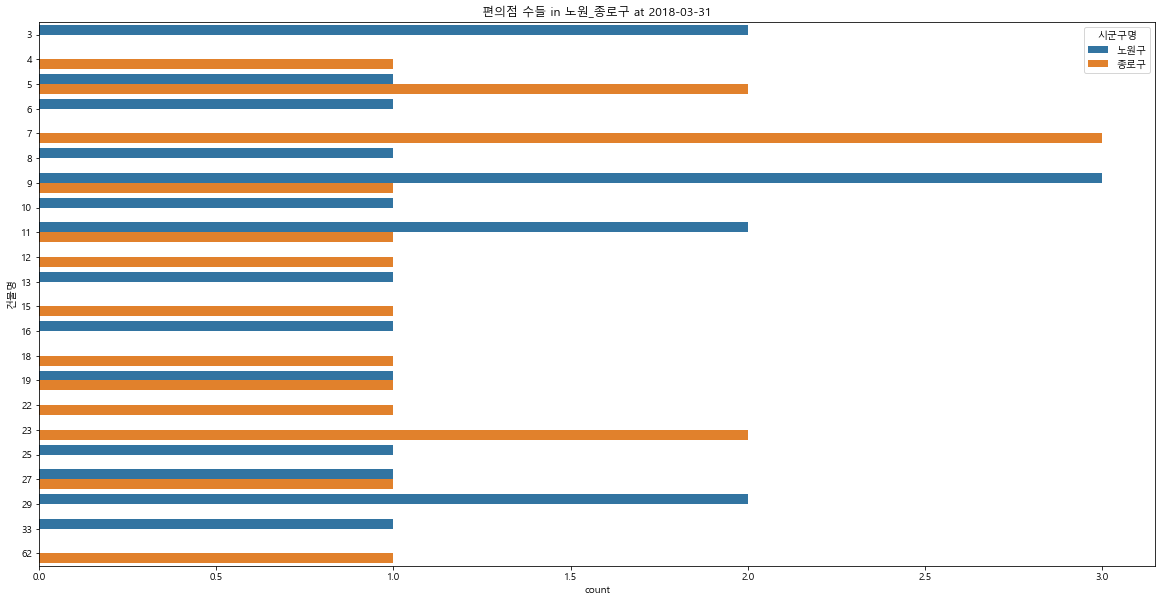

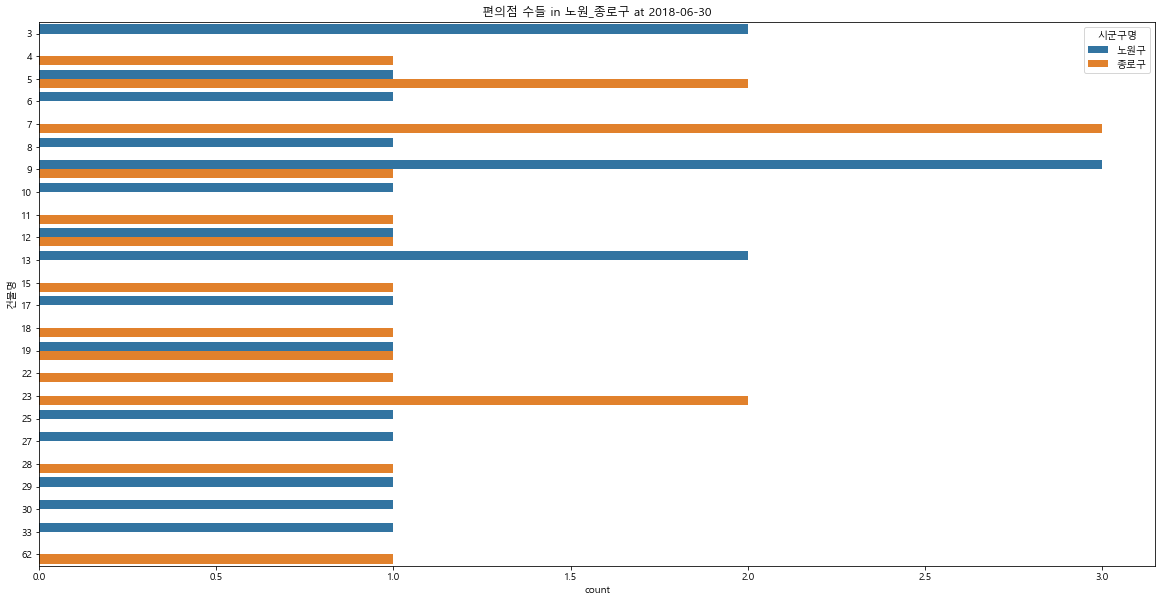

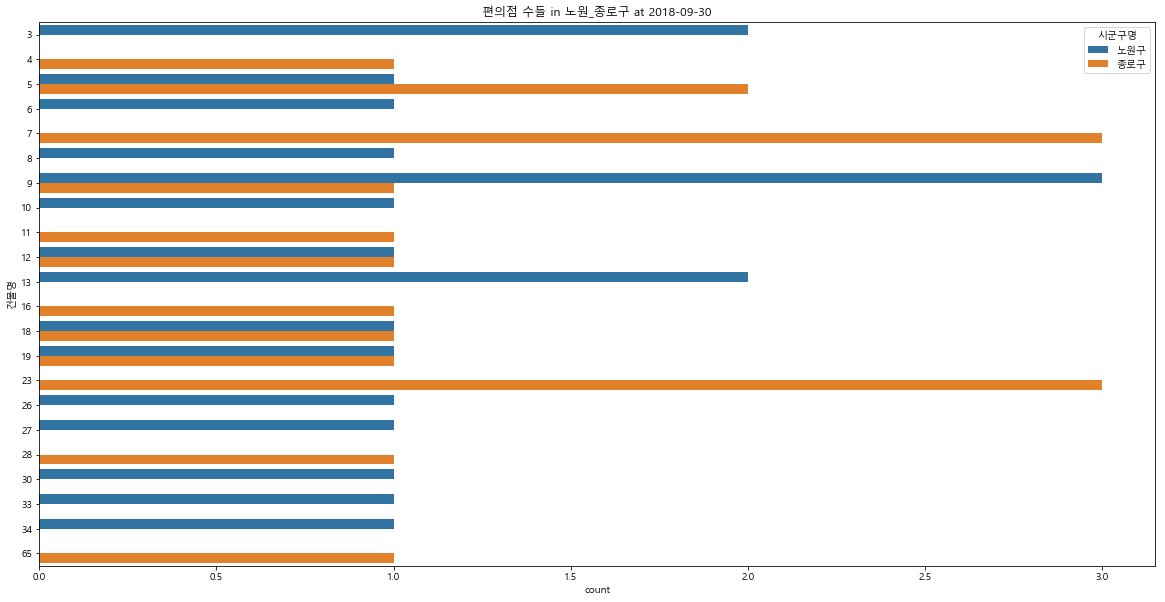

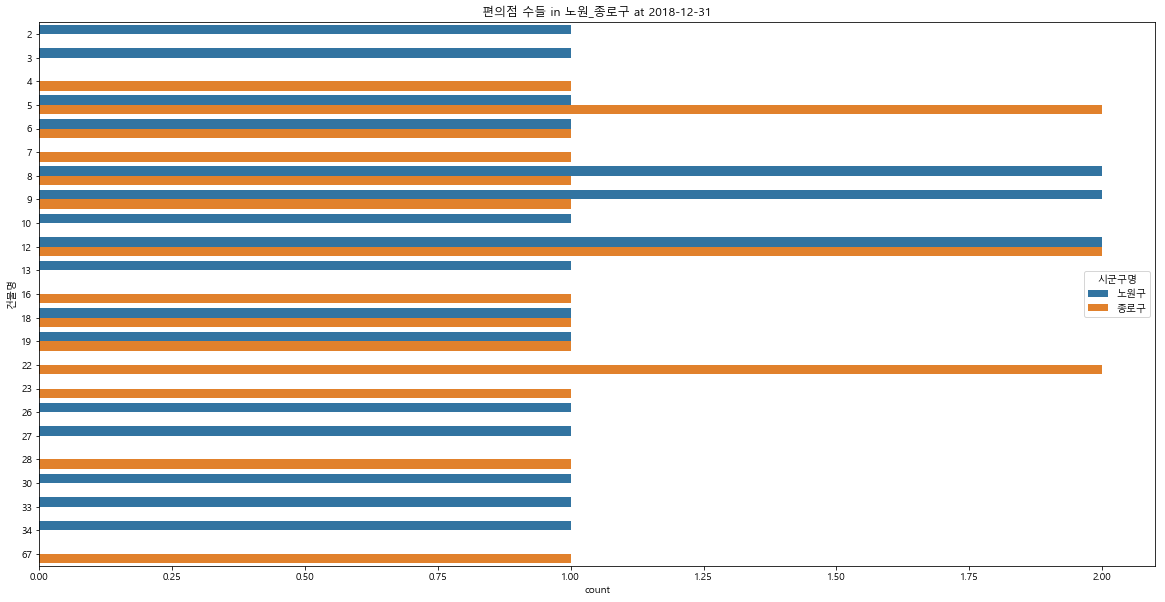

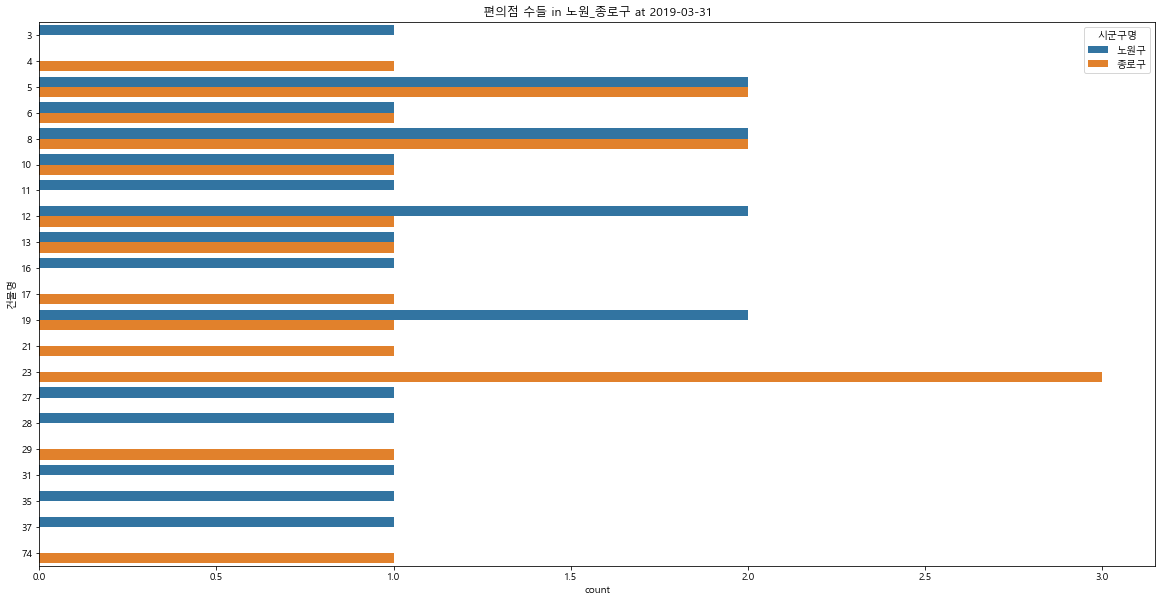

In [8]:
t2 = gs_cri1.groupby(['time','시군구명','행정동명'])['건물명'].size().reset_index(level=[0,1,2])
#t2[(t2['시군구명'] =='노원구') & (t2['time']=='2018-03-31')].plot()

for i in np.unique(t2['time']):
    plt.figure(figsize=(20,10))
    plt.title('편의점 수들 ' + 'in 노원_종로구 ' + 'at ' + i)
    sns.countplot(data=t2[(t2['time']== i )],
                  y = '건물명',
                  hue = '시군구명')

## Fact 3

상호명에서 GS와 관련된 경우는 'GS','gs','지에스'가 있다.
각각 경우의 수가 939개, 5개, 45개이다.

In [9]:
a = gs_cri1['상호명'].tolist()
b = ' '.join(a)
print(b.count('GS'))

939


In [10]:
print(b.count('gs'))

5


In [11]:
print(b.count('지에스'))

45


## 구체적인 GS편의점 갯수를 구한다.

In [12]:
gs_cri1 = gs_cri1.reset_index()
gs_cri1 = gs_cri1.iloc[:,1:]
gs_cri1.head()

,상호명,지점명,상권업종대분류명,상권업종중분류명,상권업종소분류명,표준산업분류명,시도명,시군구명,행정동명,법정동명,지번주소,건물명,도로명주소,경도,위도,time
0,비지에프리테일서울산업대제2학생회관점,NaN,소매,종합소매점,편의점,체인화 편의점,서울특별시,노원구,공릉2동,공릉동,서울특별시 노원구 공릉동 172,서울과학기술대학교,서울특별시 노원구 공릉로 232,127.076771,37.633069,2018-03-31
1,GS25광운문화관,NaN,소매,종합소매점,편의점,체인화 편의점,서울특별시,노원구,월계1동,월계동,서울특별시 노원구 월계동 466,광운대학교,서울특별시 노원구 광운로 21,127.057576,37.619816,2018-03-31
2,GS25,명륜스타점,소매,종합소매점,편의점,체인화 편의점,서울특별시,종로구,혜화동,명륜4가,서울특별시 종로구 명륜4가 113-1,대학로스타시스빌딩,서울특별시 종로구 대학로11길 23,127.000401,37.582052,2018-03-31
3,CU,노원스타점,소매,종합소매점,편의점,체인화 편의점,서울특별시,노원구,상계2동,상계동,서울특별시 노원구 상계동 617,화랑빌딩,서울특별시 노원구 상계로 64,127.062255,37.655787,2018-03-31
4,엘지이십오시종로안국,NaN,소매,종합소매점,편의점,체인화 편의점,서울특별시,종로구,가회동,재동,서울특별시 종로구 재동 104-1,NaN,서울특별시 종로구 율곡로 61,126.985910,37.576928,2018-03-31


In [13]:
def find_gs(data):
    
    p = list()
    for j in range(len(data)):
        for u in ['GS','gs','지에스']:
            op = u in data['상호명'][j]
            p.append(op)
        
    def split_list(l,n):
        for i in range(0,len(l),n):
            yield l[i:i+n]

    p2 = list(split_list(p,3))
    
    li = list()
    for i in range(len(p2)):
        if (sum(p2[i])!=0):
            li.append(i)
        else:
            continue

    data2 = data.iloc[li,:]
    return data2

In [14]:
gs_num = find_gs(gs_cri1)

가회동 같은 경우, '2019/03' 편의점 수가 1개 이후로 관측되지 않았다. 또한 GS 리테일의 다른 계열사인 'GS 슈퍼마켓', 'LALAVLA'도 또한 존재하지 않는다.

In [15]:
gs_num.groupby(['행정동명','time']).size().reset_index(level=[0,1])

,행정동명,time,0
0,가회동,2019-03-31,1
1,공릉1동,2018-03-31,8
2,공릉1동,2018-06-30,8
3,공릉1동,2018-09-30,8
4,공릉1동,2018-12-31,8
5,공릉1동,2019-03-31,10
6,공릉2동,2018-03-31,11
7,공릉2동,2018-06-30,11
8,공릉2동,2018-09-30,11
9,공릉2동,2018-12-31,11


In [16]:
gs_num.groupby(['행정동명','time']).size().reset_index(level=[0,1])['행정동명'].value_counts()

종로1.2.3.4가동    5
월계1동           5
상계1동           5
공릉1동           5
중계본동           5
창신2동           5
월계3동           5
상계6.7동         5
삼청동            5
상계10동          5
청운효자동          5
무악동            5
숭인1동           5
상계8동           5
중계1동           5
혜화동            5
월계2동           5
공릉2동           5
중계2.3동         5
중계4동           5
종로5.6가동        5
하계1동           5
창신1동           5
상계9동           5
상계3.4동         5
평창동            5
사직동            5
이화동            5
상계5동           5
하계2동           5
상계2동           5
부암동            5
창신3동           5
교남동            5
숭인2동           5
가회동            1
Name: 행정동명, dtype: int64

In [17]:
gs_num.to_csv('가공데이터/GS편의점_종로노원구.csv',encoding='utf-8')

In [18]:
gs_total2 = gs_num.groupby(['행정동명','time']).size().reset_index(level=[0,1])
gs_total2

,행정동명,time,0
0,가회동,2019-03-31,1
1,공릉1동,2018-03-31,8
2,공릉1동,2018-06-30,8
3,공릉1동,2018-09-30,8
4,공릉1동,2018-12-31,8
5,공릉1동,2019-03-31,10
6,공릉2동,2018-03-31,11
7,공릉2동,2018-06-30,11
8,공릉2동,2018-09-30,11
9,공릉2동,2018-12-31,11


지수 개발을 위해 '2019-03-31'이전 시점의 관측치가 존재하지 않는 가회동의 GS 계열사 수를 1로 산정한다.

In [19]:
gs_total2.loc[-1] = ['가회동','2018-12-31',1]
gs_total2.loc[-2] = ['가회동','2018-09-30',1]
gs_total2.loc[-3] = ['가회동','2018-06-30',1]
gs_total2.loc[-4] = ['가회동','2018-03-31',1]
gs_total2.index = gs_total2.index +4
gs_total2 = gs_total2.sort_index()
gs_total2 = gs_total2.rename(columns = {'행정동명': 'ADMD_NM','time' : 'cri',0:'gs_num'})

# 유동인구데이터와 유통데이터 합치기 #

In [20]:
tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13140 entries, 0 to 13139
Data columns (total 64 columns):
STD_YM       13140 non-null int64
STD_YMD      13140 non-null int64
HDONG_CD     13140 non-null int64
HDONG_NM     13140 non-null object
MAN_0004     13140 non-null float64
MAN_0509     13140 non-null float64
MAN_1014     13140 non-null float64
MAN_1519     13140 non-null float64
MAN_2024     13140 non-null float64
MAN_2529     13140 non-null float64
MAN_3034     13140 non-null float64
MAN_3539     13140 non-null float64
MAN_4044     13140 non-null float64
MAN_4549     13140 non-null float64
MAN_5054     13140 non-null float64
MAN_5559     13140 non-null float64
MAN_6064     13140 non-null float64
MAN_6569     13140 non-null float64
MAN_70U      13140 non-null float64
WMAN_0004    13140 non-null float64
WMAN_0509    13140 non-null float64
WMAN_1014    13140 non-null float64
WMAN_1519    13140 non-null float64
WMAN_2024    13140 non-null float64
WMAN_2529    13140 non-null float6

In [21]:
tp['date'] = pd.to_datetime(tp['date'],format='%Y-%m-%d')
tp['weekday']=tp['date'].dt.day_name()
tp['year'] = tp['date'].dt.year
tp['month'] = tp['date'].dt.month
tp['day'] = tp['date'].dt.day

In [22]:
tp = tp.rename(columns = {'HDONG_NM':'ADMD_NM'})
circulation = circulation.rename(columns = {'time':'date'})

In [23]:
circulation['date'] = pd.to_datetime(circulation['date'],format='%Y-%m-%d')
circulation['weekday']=circulation['date'].dt.day_name()
circulation['year'] = circulation['date'].dt.year
circulation['month'] = circulation['date'].dt.month
circulation['day'] = circulation['date'].dt.day

In [24]:
tp_cir = pd.merge(tp,circulation,on=['SGNG_NM','HDONG_CD','ADMD_NM','year','month','day',
                                     'date','weekday'])

In [25]:
tp_cir.head()

,STD_YM,STD_YMD,HDONG_CD,ADMD_NM,MAN_0004,MAN_0509,MAN_1014,MAN_1519,MAN_2024,MAN_2529,...,70_P,80_P,AMT_IND_10,AMT_IND_20,AMT_IND_30,AMT_IND_40,AMT_IND_50,AMT_IND_60,AMT_IND_70,AMT_IND_80
0,201804,20180401,1111051500,청운효자동,0.05,78.93,403.26,642.66,984.24,1792.30,...,0.013092,0.003823,0.205617,0.220762,0.246737,0.011523,0.039634,0.000195,0.009648,0.002817
1,201804,20180401,1111053000,사직동,1.25,262.54,1207.22,2177.88,4076.89,6887.72,...,0.002467,0.009250,0.298765,0.324666,0.440246,0.057263,0.116511,0.006277,0.003105,0.011640
2,201804,20180401,1111054000,삼청동,0.00,78.07,255.24,331.09,654.32,1264.86,...,0.013212,0.006712,0.171292,0.166414,0.218722,0.043838,0.060467,0.000000,0.008907,0.004525
3,201804,20180401,1111055000,부암동,0.00,228.50,753.31,981.54,1615.77,2732.00,...,0.012295,0.001756,0.420896,0.220083,0.285687,0.027028,0.037020,0.005957,0.012429,0.001775
4,201804,20180401,1111056000,평창동,0.00,354.38,1500.63,1963.08,2593.07,4927.24,...,0.007270,0.001577,0.315350,0.270848,0.265754,0.014927,0.137102,0.000000,0.007364,0.001598


# GS Index Development

## 세부지표

단위 기준을 살펴보면 다음과 같다 :

   - 동별매출지수 : 동 기준 / 성별 무시 / 연령 무시
   - 유동인구 : 동 기준 / 성별 고려 / 연령 고려
   - GS점포수 : 동 기준 / 성별 무시 / 연령 무시

GS상점수 Mapping method: 
- 2018/03 : 2018/03,04,05
- 2018/06 : 2018/06,07,08
- 2018/09 : 2018/09,10,11
- 2018/12 : 2018/12, 2019/01,02
- 2019/03 : 2019/03,04

In [26]:
tp_cir['tp_method1'] = np.sum(tp_cir.iloc[:,4:33],axis=1)

In [27]:
a = '2018-03-31'
b = '2018-06-30'
c = '2018-09-30'
d = '2018-12-31'
e = '2019-03-31'

tp_cir['cri']=1
tp_cir.loc[tp_cir['date'] < '2018-06-01','cri'] = a 
tp_cir.loc[((tp_cir['date']>='2018-06-01')&(tp_cir['date']<'2018-09-01')),'cri']=b
tp_cir.loc[((tp_cir['date']>='2018-09-01')&(tp_cir['date']<'2018-12-01')),'cri'] =c
tp_cir.loc[((tp_cir['date']>='2018-12-01')&(tp_cir['date']<'2019-03-01')),'cri'] =d
tp_cir.loc[tp_cir['date'] >= '2019-03-01','cri'] = e   

In [28]:
tp_cir.head()

,STD_YM,STD_YMD,HDONG_CD,ADMD_NM,MAN_0004,MAN_0509,MAN_1014,MAN_1519,MAN_2024,MAN_2529,...,AMT_IND_10,AMT_IND_20,AMT_IND_30,AMT_IND_40,AMT_IND_50,AMT_IND_60,AMT_IND_70,AMT_IND_80,tp_method1,cri
0,201804,20180401,1111051500,청운효자동,0.05,78.93,403.26,642.66,984.24,1792.30,...,0.205617,0.220762,0.246737,0.011523,0.039634,0.000195,0.009648,0.002817,35661.86,2018-03-31
1,201804,20180401,1111053000,사직동,1.25,262.54,1207.22,2177.88,4076.89,6887.72,...,0.298765,0.324666,0.440246,0.057263,0.116511,0.006277,0.003105,0.011640,127998.59,2018-03-31
2,201804,20180401,1111054000,삼청동,0.00,78.07,255.24,331.09,654.32,1264.86,...,0.171292,0.166414,0.218722,0.043838,0.060467,0.000000,0.008907,0.004525,24883.83,2018-03-31
3,201804,20180401,1111055000,부암동,0.00,228.50,753.31,981.54,1615.77,2732.00,...,0.420896,0.220083,0.285687,0.027028,0.037020,0.005957,0.012429,0.001775,68236.85,2018-03-31
4,201804,20180401,1111056000,평창동,0.00,354.38,1500.63,1963.08,2593.07,4927.24,...,0.315350,0.270848,0.265754,0.014927,0.137102,0.000000,0.007364,0.001598,134630.55,2018-03-31


In [29]:
tp_cir_gs = pd.merge(tp_cir,gs_total2,on=['ADMD_NM','cri'])
tp_cir_gs.head()

,STD_YM,STD_YMD,HDONG_CD,ADMD_NM,MAN_0004,MAN_0509,MAN_1014,MAN_1519,MAN_2024,MAN_2529,...,AMT_IND_20,AMT_IND_30,AMT_IND_40,AMT_IND_50,AMT_IND_60,AMT_IND_70,AMT_IND_80,tp_method1,cri,gs_num
0,201804,20180401,1111051500,청운효자동,0.05,78.93,403.26,642.66,984.24,1792.30,...,0.220762,0.246737,0.011523,0.039634,0.000195,0.009648,0.002817,35661.86,2018-03-31,5
1,201804,20180402,1111051500,청운효자동,0.00,52.83,400.93,1342.24,1410.78,2563.21,...,0.212723,0.350041,0.032123,0.026610,0.000941,0.002573,0.006224,49106.88,2018-03-31,5
2,201804,20180403,1111051500,청운효자동,0.00,65.56,378.82,1288.09,1417.84,2363.31,...,0.178108,0.260615,0.008683,0.035840,0.003680,0.003970,0.001704,49809.81,2018-03-31,5
3,201804,20180404,1111051500,청운효자동,0.00,59.17,516.56,1429.78,1423.40,2407.96,...,0.159389,0.254388,0.022813,0.027637,0.001568,0.004369,0.003330,51090.27,2018-03-31,5
4,201804,20180405,1111051500,청운효자동,0.00,53.83,399.61,1243.01,1272.59,2223.17,...,0.147404,0.174190,0.013078,0.031264,0.003691,0.005212,0.000632,48170.66,2018-03-31,5


In [30]:
tp_cir_gs.drop(['TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04',
       'TMST_05', 'TMST_06', 'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10',
       'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16',
       'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22',
       'TMST_23'], axis = 1, inplace = True)
tp_cir_gs.columns

Index(['STD_YM', 'STD_YMD', 'HDONG_CD', 'ADMD_NM', 'MAN_0004', 'MAN_0509',
       'MAN_1014', 'MAN_1519', 'MAN_2024', 'MAN_2529', 'MAN_3034', 'MAN_3539',
       'MAN_4044', 'MAN_4549', 'MAN_5054', 'MAN_5559', 'MAN_6064', 'MAN_6569',
       'MAN_70U', 'WMAN_0004', 'WMAN_0509', 'WMAN_1014', 'WMAN_1519',
       'WMAN_2024', 'WMAN_2529', 'WMAN_3034', 'WMAN_3539', 'WMAN_4044',
       'WMAN_4549', 'WMAN_5054', 'WMAN_5559', 'WMAN_6064', 'WMAN_6569',
       'WMAN_70U', 'SGNG_NM', 'year', 'day', 'month', 'date', 'weekday',
       'values', 'SGNG_CD', 'LENGTH', 'AREA', '10_P', '20_P', '30_P', '40_P',
       '50_P', '60_P', '70_P', '80_P', 'AMT_IND_10', 'AMT_IND_20',
       'AMT_IND_30', 'AMT_IND_40', 'AMT_IND_50', 'AMT_IND_60', 'AMT_IND_70',
       'AMT_IND_80', 'tp_method1', 'cri', 'gs_num'],
      dtype='object')

In [31]:
gs_num2 = gs_num.loc[:,['상호명','행정동명','경도','위도','time']].reset_index().iloc[:,1:]
gs_num2['period'] = gs_num2['time'] 
gs_num2['period'] = gs_num2['period'].replace(['2018-03-31','2018-06-30','2018-09-30','2018-12-31','2019-03-31'],[1,2,3,4,5])

a1803 = [list(j) for j in zip(gs_num[gs_num['time'] == '2018-03-31']['위도'],gs_num[gs_num['time'] == '2018-03-31']['경도'])]
# a1806 = [list(j) for j in zip(gs_num[gs_num['time'] == '2018-06-30']['위도'],gs_num[gs_num['time'] == '2018-06-30']['경도'])]
# a1809 = [list(j) for j in zip(gs_num[gs_num['time'] == '2018-09-30']['위도'],gs_num[gs_num['time'] == '2018-09-30']['경도'])]
# a1812 = [list(j) for j in zip(gs_num[gs_num['time'] == '2018-12-31']['위도'],gs_num[gs_num['time'] == '2018-12-31']['경도'])]
a1903 = [list(j) for j in zip(gs_num[gs_num['time'] == '2019-03-31']['위도'],gs_num[gs_num['time'] == '2019-03-31']['경도'])]

### 18년 3월 기준 종로구와 노원구의 GS 편의점을 플롯팅하면 다음과 같다.

In [32]:
jongro_nowon_map = folium.Map(location = [np.mean([i[0] for i in a1803]),np.mean([i[1] for i in a1803])],
                              zoom_start = 10)

for j in zip([i[0] for i in a1803],[i[1] for i in a1803]):
    folium.Circle(radius = 100,
                  location = j,
                  fill = False).add_to(jongro_nowon_map)

jongro_nowon_map

### 19년 3월 기준 종로구와 노원구의 GS 편의점을 플롯팅하면 다음과 같다.

In [33]:
jongro_nowon_map2 = folium.Map(location = [np.mean([i[0] for i in a1903]),np.mean([i[1] for i in a1903])],
                              zoom_start = 10)

for j in zip([i[0] for i in a1903],[i[1] for i in a1903]):
    folium.Circle(radius = 100,
                  location = j,
                  fill = False).add_to(jongro_nowon_map2)

jongro_nowon_map2

### 동을 기준으로 편의점간의 거리를 구한다

- 각 시점을 고려한다.
- 각 동의 편의점 간의 최소, 최대 , 중위거리를 구한다.

In [34]:
# Approximate radius of earth(km)
r = 6373.0

def dist_func(lat1,lon1,lat2,lon2): # 위도1,경도1,위도2,경도2
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    k1 = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    k2 = 2 * atan2(sqrt(k1),sqrt(1-k1))
    distance = r * k2
    return distance

In [35]:
gs_num2

,상호명,행정동명,경도,위도,time,period
0,GS25광운문화관,월계1동,127.057576,37.619816,2018-03-31,1
1,GS25,혜화동,127.000401,37.582052,2018-03-31,1
2,GS25석계그랑빌,월계3동,127.067060,37.618720,2018-03-31,1
3,GS노원중앙점,상계6.7동,127.063160,37.654172,2018-03-31,1
4,지에스25상명사랑,부암동,126.958506,37.600143,2018-03-31,1
5,GS25노원한신,상계5동,127.069370,37.666016,2018-03-31,1
6,GS25공릉에이스,공릉1동,127.075801,37.619943,2018-03-31,1
7,GS25,상계3.4동,127.083177,37.672323,2018-03-31,1
8,지에스25혜화경찰서,종로1.2.3.4가동,126.998444,37.572565,2018-03-31,1
9,GS25중계행복,중계본동,127.085048,37.643649,2018-03-31,1


In [36]:
p1 = []
for i in np.unique(gs_num2['행정동명']):
    w = gs_num2[gs_num2['행정동명'] == i]
    for q in np.unique(gs_num2['period']):
        t = w[w['period'] == q] 
        l1 = t['위도'].values
        l2 = t['경도'].values
    
        p2 = []
        if len(t) != 1:
            for j in range(len(l1)-1):
                lo = l1[j],l2[j],l1[j+1],l2[j+1]
                lat1,lon1,lat2,lon2 = lo
                ww = dist_func(lat1,lon1,lat2,lon2)
                p2.append(ww)
        else:
            pass
        p1.append(p2)

max0 = []
min0 = []
median0 = []

for i in range(len(p1)):
    if not p1[i]:
        p1[i] = [0]
    else:
        p1[i] = p1[i]
        
    max_v = np.max(p1[i]).tolist()
    min_v = np.min(p1[i]).tolist()
    median_v = np.median(p1[i]).tolist()
    
    max0.append(max_v)
    min0.append(min_v)
    median0.append(median_v)

In [37]:
t = [[i] * 5 for i in np.unique(gs_num2['행정동명'])] 
t2 = [item for i in t for item in i]
q1 = [np.unique(gs_num2['time']).tolist()] * 36
q2 = [item for i in q1 for item in i]

table = pd.DataFrame({'ADMD_NM' : t2,
                      'cri' : q2,
                      'min_gs' : min0,
                      'max_gs' : max0,
                      'median_gs' : median0
                     })

In [38]:
table.to_csv('가공데이터/gs_distance.csv',encoding='utf-8')

In [39]:
tp_cir_gs = pd.merge(tp_cir_gs,table,on = ['ADMD_NM','cri'])

### 'gsindex1' : 동별매출지수 / 동별 유동인구
- 동별매출지수와 GS점포수와 마찬가지로 성별과 연령을 무시한 유동인구로 만들어 GS index2을 생성한다.
- 다만 지수를 생성할 때 동별 매출지수(%)와 동별 유동인구(명)의 단위가 다르므로 변수들을 정규화한 후 지수를 생성한다.

In [40]:
a1 = (tp_cir_gs['values'] - tp_cir_gs['values'].mean()) / tp_cir_gs['values'].std()
a2 = (tp_cir_gs['tp_method1'] - tp_cir_gs['tp_method1'].mean()) / tp_cir_gs['tp_method1'].std()
tp_cir_gs['gsindex1'] = a1 / a2

# {유동 + 유통 + 환경} data 만들기 
- 환경데이터 기준 columns : 'date', 'year', 'month', 'day', 'district', 'gu'	
- [유동+유통] 데이터 기준 columns : 'date', 'year', 'month', 'day', 'ADMD_NM', 'SGNG_NM'

In [41]:
tp_cir_gs.head()

,STD_YM,STD_YMD,HDONG_CD,ADMD_NM,MAN_0004,MAN_0509,MAN_1014,MAN_1519,MAN_2024,MAN_2529,...,AMT_IND_60,AMT_IND_70,AMT_IND_80,tp_method1,cri,gs_num,min_gs,max_gs,median_gs,gsindex1
0,201804,20180401,1111051500,청운효자동,0.05,78.93,403.26,642.66,984.24,1792.30,...,0.000195,0.009648,0.002817,35661.86,2018-03-31,5,0.103785,0.617223,0.423818,1.614251
1,201804,20180402,1111051500,청운효자동,0.00,52.83,400.93,1342.24,1410.78,2563.21,...,0.000941,0.002573,0.006224,49106.88,2018-03-31,5,0.103785,0.617223,0.423818,1.314517
2,201804,20180403,1111051500,청운효자동,0.00,65.56,378.82,1288.09,1417.84,2363.31,...,0.003680,0.003970,0.001704,49809.81,2018-03-31,5,0.103785,0.617223,0.423818,2.222562
3,201804,20180404,1111051500,청운효자동,0.00,59.17,516.56,1429.78,1423.40,2407.96,...,0.001568,0.004369,0.003330,51090.27,2018-03-31,5,0.103785,0.617223,0.423818,2.321274
4,201804,20180405,1111051500,청운효자동,0.00,53.83,399.61,1243.01,1272.59,2223.17,...,0.003691,0.005212,0.000632,48170.66,2018-03-31,5,0.103785,0.617223,0.423818,2.838878


In [42]:
tp_cir_gs.drop(['STD_YM','STD_YMD','HDONG_CD','SGNG_CD'], axis = 1, inplace = True)
tp_cir_gs.head()

,ADMD_NM,MAN_0004,MAN_0509,MAN_1014,MAN_1519,MAN_2024,MAN_2529,MAN_3034,MAN_3539,MAN_4044,...,AMT_IND_60,AMT_IND_70,AMT_IND_80,tp_method1,cri,gs_num,min_gs,max_gs,median_gs,gsindex1
0,청운효자동,0.05,78.93,403.26,642.66,984.24,1792.30,1936.10,2060.54,1787.98,...,0.000195,0.009648,0.002817,35661.86,2018-03-31,5,0.103785,0.617223,0.423818,1.614251
1,청운효자동,0.00,52.83,400.93,1342.24,1410.78,2563.21,2746.47,3117.10,3076.14,...,0.000941,0.002573,0.006224,49106.88,2018-03-31,5,0.103785,0.617223,0.423818,1.314517
2,청운효자동,0.00,65.56,378.82,1288.09,1417.84,2363.31,2710.82,3047.08,2930.84,...,0.003680,0.003970,0.001704,49809.81,2018-03-31,5,0.103785,0.617223,0.423818,2.222562
3,청운효자동,0.00,59.17,516.56,1429.78,1423.40,2407.96,2804.92,3122.00,2970.22,...,0.001568,0.004369,0.003330,51090.27,2018-03-31,5,0.103785,0.617223,0.423818,2.321274
4,청운효자동,0.00,53.83,399.61,1243.01,1272.59,2223.17,2713.58,2978.93,2995.57,...,0.003691,0.005212,0.000632,48170.66,2018-03-31,5,0.103785,0.617223,0.423818,2.838878


In [43]:
tp_cir_gs.rename(columns = {'ADMD_NM' : 'district'},inplace=True)

## 환경기상데이터의 행정동과 {유통+유동}데이터의 행정동을 맞추는 것이 중요하다.

In [44]:
# 환경기상 데이터에 존재하는 행정동 구하기
len(np.unique(fm2['district']))

28

In [45]:
len(np.unique(tp_cir_gs['district']))

36

In [46]:
tp_cir_gs3 = tp_cir_gs[tp_cir_gs['district'].isin(np.unique(fm2['district']))]
np.unique(tp_cir_gs3['district'])

array(['가회동', '공릉1동', '공릉2동', '교남동', '부암동', '사직동', '상계10동', '상계1동',
       '상계2동', '상계3.4동', '상계5동', '상계6.7동', '숭인2동', '월계1동', '월계3동', '이화동',
       '종로1.2.3.4가동', '종로5.6가동', '중계2.3동', '중계본동', '창신1동', '창신3동',
       '청운효자동', '평창동', '하계1동', '혜화동'], dtype=object)

In [47]:
print(len(np.unique(fm2['district'])))
print(len(np.unique(tp_cir_gs['district'])))
print(len(np.unique(tp_cir_gs3['district'])))

28
36
26


In [48]:
fm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10220 entries, 0 to 10219
Data columns (total 29 columns):
date                    10220 non-null object
year                    10220 non-null int64
quarter                 10220 non-null int64
month                   10220 non-null int64
weekday                 10220 non-null object
day                     10220 non-null int64
district                10220 non-null object
gu                      10220 non-null object
p10_most_freq_day       10220 non-null object
p10_mean_day            10220 non-null float64
p10_25per               10220 non-null float64
p10_median_day          10220 non-null float64
p10_75per               10220 non-null float64
p25_most_freq_day       10220 non-null object
p25_mean_day            10220 non-null float64
p25_25per               10220 non-null float64
p25_median_day          10220 non-null float64
p25_75per               10220 non-null float64
humi_mean_day           10220 non-null float64
humi_median_

In [49]:
fm2['date'] = pd.to_datetime(fm2['date'])
fm2.drop('gu', axis=1, inplace=True)
fm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10220 entries, 0 to 10219
Data columns (total 28 columns):
date                    10220 non-null datetime64[ns]
year                    10220 non-null int64
quarter                 10220 non-null int64
month                   10220 non-null int64
weekday                 10220 non-null object
day                     10220 non-null int64
district                10220 non-null object
p10_most_freq_day       10220 non-null object
p10_mean_day            10220 non-null float64
p10_25per               10220 non-null float64
p10_median_day          10220 non-null float64
p10_75per               10220 non-null float64
p25_most_freq_day       10220 non-null object
p25_mean_day            10220 non-null float64
p25_25per               10220 non-null float64
p25_median_day          10220 non-null float64
p25_75per               10220 non-null float64
humi_mean_day           10220 non-null float64
humi_median_day         10220 non-null float64
hum

In [50]:
gs_whole_table = pd.merge(fm2, tp_cir_gs3, on = ['date','year','month','day','district','weekday'])
gs_whole_table

,date,year,quarter,month,weekday,day,district,p10_most_freq_day,p10_mean_day,p10_25per,...,AMT_IND_60,AMT_IND_70,AMT_IND_80,tp_method1,cri,gs_num,min_gs,max_gs,median_gs,gsindex1
0,2018-04-01,2018,2,4,Sunday,1,가회동,나쁨,66.773843,57.656944,...,0.007142,0.015259,0.000732,17191.22,2018-03-31,1,0.000000,0.000000,0.000000,1.211474
1,2018-04-02,2018,2,4,Monday,2,가회동,나쁨,64.771759,56.862500,...,0.001952,0.001996,0.009537,32378.20,2018-03-31,1,0.000000,0.000000,0.000000,0.997001
2,2018-04-03,2018,2,4,Tuesday,3,가회동,나쁨,63.759838,48.220833,...,0.005172,0.007284,0.007231,35185.26,2018-03-31,1,0.000000,0.000000,0.000000,0.451986
3,2018-04-04,2018,2,4,Wednesday,4,가회동,좋음,18.720500,10.300589,...,0.013560,0.091377,0.003216,34655.78,2018-03-31,1,0.000000,0.000000,0.000000,0.085016
4,2018-04-05,2018,2,4,Thursday,5,가회동,좋음,12.597801,10.083333,...,0.018180,0.030341,0.011542,33459.81,2018-03-31,1,0.000000,0.000000,0.000000,1.012667
5,2018-04-06,2018,2,4,Friday,6,가회동,매우나쁨,82.220023,17.604167,...,0.011817,0.031273,0.000976,33103.04,2018-03-31,1,0.000000,0.000000,0.000000,0.697018
6,2018-04-07,2018,2,4,Saturday,7,가회동,나쁨,40.517824,34.515278,...,0.001561,0.020759,0.004747,23079.62,2018-03-31,1,0.000000,0.000000,0.000000,0.809094
7,2018-04-08,2018,2,4,Sunday,8,가회동,보통,33.939120,30.209722,...,0.000000,0.086743,0.009405,19263.98,2018-03-31,1,0.000000,0.000000,0.000000,-0.105361
8,2018-04-09,2018,2,4,Monday,9,가회동,나쁨,41.764352,37.831944,...,0.001561,0.037084,0.004436,32045.52,2018-03-31,1,0.000000,0.000000,0.000000,1.014847
9,2018-04-10,2018,2,4,Tuesday,10,가회동,나쁨,47.675463,35.295833,...,0.001171,0.032648,0.009458,35810.73,2018-03-31,1,0.000000,0.000000,0.000000,1.022382


In [51]:
gs_whole_table.to_csv('가공데이터/merge_유통_유동_환경_소상공인_edit1.csv',encoding='utf-8')